# Require library

In [2]:
import pandas as pd
import pandas_ta as ta
import requests
import time
import datetime
import json
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
from io import StringIO
#from google.colab import data_table
#data_table.enable_dataframe_formatter()

Matplotlib is building the font cache; this may take a moment.


In [ ]:
def get_stock_list():
  res = requests.get("https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y")
  df = pd.read_html(res.text)[0]        # Parse the Source Code into a Pandas DataFrame
  df = df.drop([0,1,4,5,8,9],axis = 1)  # Drop Useless Columns
  df.columns = df.iloc[0]               # Replace DataFrame Columns Title
  df = df.iloc[1:]
  return df

In [ ]:
def plot_stcok_k_chart(CLIENT_ID, stock="0050" , date_from='2020-01-01' ):
  """
  進行個股K線繪製，回傳至於雲端圖床的連結。將顯示包含5MA、20MA及量價關係，預設為'2020-01-01'迄今收盤價。
  :stock :個股代碼(字串)，預設0050。
  :date_from :起始日(字串)，格式為%Y-%m-%d，預設自2020-01-01起。
  """
  stock = str(stock)+".tw"
  # df = web.DataReader(stock, 'yahoo', date_from) # 已知有未修復的錯誤
  df = yf.download(stock, date_from)
  mpf.plot(df,type='candle',mav=(5,20),volume=True,title=stock.upper() ,savefig='testsave.png')
  PATH = "testsave.png"
  im = pyimgur.Imgur(CLIENT_ID)
  uploaded_image = im.upload_image(PATH, title=stock+" candlestick chart")
  return uploaded_image.link

# Main get stocker data

In [15]:
import requests
from io import StringIO
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime
import time
import sqlite3

class Stocker:
  def __init__(self, n_days, db_name):
    #self.name = name
    self.today = datetime.datetime.now()
    self.country = "TW"
    self.source = "TWSE"
    self.rank = ""
    self.data = None
    self.data_ta = None
    self.OHLCV = None
    self.n_days = n_days
    self.db_name = db_name

  def crawl_price(self, date):
    r = requests.post('http://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + str(date).split(' ')[0].replace('-','') + '&type=ALL')
    #ret = pd.read_csv(StringIO("\n".join([i.translate({ord(c): None for c in ' '})
    #                                    for i in r.text.split('\n')
    #                                    if len(i.split('",')) == 17 and i[0] != '='])), header=0)
    ret = pd.read_csv(StringIO(r.text.replace("=", "")),
            header=["證券代號" in l for l in r.text.split("\n")].index(True)-1)
    ret = ret.set_index('證券代號')
    ret = ret[:'備註:'][:-1]
    ret = ret.loc[:,:'本益比']
    ret['成交金額'] = ret['成交金額'].str.replace(',','')
    ret['成交股數'] = ret['成交股數'].str.replace(',','')
    ret['成交筆數'] = ret['成交筆數'].str.replace(',','')
    ret['交易日']= date.date()
    return ret


  def get_twse_stocker_date_range_date(
      self,
      startdate=datetime.datetime.now(),
      n_days=10,
      sleep_time=10,
      allow_continuous_fail_count=5,
  ):
      data = {}
      date = startdate
      fail_count = 0
      while len(data) < n_days:

          print('parsing', date)
          # 使用 crawPrice 爬資料

          try:
              if self.data is not None:
                if pd.to_datetime(date.date()) in self.data.index.levels[0]:
                  print('skip! data is already having')
                  data[date.date()] = self.data.loc[[date.date()]].droplevel(level='交易日')
              else:
                # 抓資料
                data[date.date()] = self.crawl_price(date)
                print('success!')
                fail_count = 0
          except:
              # 假日爬不到
              print('fail! check the date is holiday')
              fail_count += 1
              if fail_count == allow_continuous_fail_count:
                  raise
                  break

          # 減一天
          date -= datetime.timedelta(days=1)
          time.sleep(sleep_time)
      data_ = pd.concat(data)
      data_ = self.correct_data(data=data_,get_data=True)
      if self.data is not None:
         newdata = [self.data, data_]
         self.data = pd.concat(newdata).drop_duplicates()
      else:
         self.data = data_

  def get_data(self) -> pd.DataFrame:
    self.data = pd.concat(self.get_twse_stocker_date_range_date(n_days=self.n_days))

  def get_data_ta(self):
    self.data_ta = self.data[['開盤價', '最高價', '最低價', '收盤價', '成交股數']].copy()       
    self.data_ta.columns = ['open', 'high', 'low', 'close', 'volume']
    self.data_ta = self.data_ta.swaplevel('交易日', '證券代號').sort_index()

  def add_indicators(self, df_group) -> pd.DataFrame:
    df_group_ = df_group.copy()
    if 'SMA_20' not in df_group:
      df_group_.ta.sma(length=20,append=True)
    if 'RSI_14' not in df_group:
      df_group_.ta.rsi(length=14,append=True)
    if 'MACD_12_26_9' not in df_group:
      #macd = df_group_.ta.macd()
      df_group_.ta.macd(append=True)
    #df_group_['MACD'] = macd['MACD_12_26_9']
    #df_group_['MACDh'] = macd['MACDh_12_26_9']
    #df_group_['MACDs'] = macd['MACDs_12_26_9']
    if 'STOCHk_14_3_3' not in df_group:
      df_group_.ta.stoch(append=True)
    if 'STOCHk_25_3_3' not in df_group:
      df_group_.ta.stoch(k=25, d=3, append=True)
    #kd = df_group_.ta.stoch()
    #df_group_['K'] = kd['STOCHk_14_3_3']
    #df_group_['D'] = kd['STOCHd_14_3_3']
    return df_group_ 

  def cal_data(self):
    self.data_ta = self.data_ta.groupby(level=0, group_keys=False).apply(self.add_indicators)
    #self.data_ta.columns = ['open', 'high', 'low', 'close', 'volume', 'SMA_20', 'RSI_14',
    #   'MACD', 'MACDh', 'MACDs', 'K',
    #   'D', 'STOCHh_14_3_3']

  def correct_data(self, data=None, get_data=None):
    flaot_cols = ['開盤價', '最高價', '最低價', '收盤價', '最後揭示買價', '本益比']
    int_cols = ['成交股數',	'成交筆數',	'成交金額']
    if data is None:
       data = self.data
    #data.index.names=['交易日','證券代號']
    data[flaot_cols] = data[flaot_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    data[int_cols] = data[int_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    data.index=data.index.set_levels(pd.to_datetime(data.index.levels[0]), level='交易日')
    data.index=data.index.set_levels(data.index.levels[1].astype(pd.StringDtype), level='證券代號')
    if get_data is not None:
       return data

  def save_db(self, data:pd.DataFrame, db_name:str=None) -> None:
    if db_name is None:
       db_name = self.db_name
    with sqlite3.connect(db_name) as conn:   #建立資料庫
      self.data = self.data.drop(['level_0','交易日'],axis=1)
      if self.data is not None:
        self.data.to_sql('Stocker', conn, if_exists='append', index=True)
      if self.data_ta is not None:
        self.data_ta.to_sql('Stocker_ta', conn, if_exists='append', index=True)
 
  def load_db_data(self, db_name:str=None) -> None:
    if db_name is None:
      db_name = self.db_name
    with sqlite3.connect(db_name) as conn:  #建立資料庫
      data = pd.read_sql('SELECT * FROM Stocker', conn, index_col=['交易日','證券代號'])
    #self.correct_data()
    data.index=data.index.set_levels(pd.to_datetime(data.index.levels[0]), level='交易日')
    self.data=data
  
  def load_db_data_ta(self, db_name:str=None) -> None:
    if db_name is None:
       db_name = self.db_name
    with sqlite3.connect(db_name) as conn:  #建立資料庫
      data = pd.read_sql('SELECT * FROM Stocker_ta', conn, index_col=['證券代號',	'交易日'])
    data.index=data.index.set_levels(pd.to_datetime(data.index.levels[1]), level='交易日')
    data.index=data.index.set_levels(data.index.levels[0].astype(pd.StringDtype), level='證券代號')
    self.data_ta=data

    def plotstock(self, stockno:str):
      plt.rcParams['font.family'] = [ 'Noto Sans TC', 'sans-serif', 'Noto Sans CJK TC']
      mpfrcpdict = { 'font.family' : [ 'Noto Sans TC', 'sans-serif', 'Noto Sans CJK TC']}
      s = mpf.make_mpf_style(base_mpf_style='yahoo',rc=mpfrcpdict)
      mpf.plot(self.data_ta.loc[stockno], type='candle', volume=True,

      addplot=mpf.make_addplot(self.data_ta.loc[stockno][['K','D']], panel=1, ylabel='KDJ'),

      title='股市圖', ylabel='成交價格', ylabel_lower='成交量', figratio=(20, 10),style=s)

In [8]:
Stocker2.data.index.dtypes

AttributeError: 'NoneType' object has no attribute 'index'

In [ ]:
Stocker2.data.dtypes

level_0     object
證券名稱        object
成交股數         int64
成交筆數         int64
成交金額         int64
開盤價        float64
最高價        float64
最低價        float64
收盤價        float64
漲跌(+/-)     object
漲跌價差       float64
最後揭示買價     float64
最後揭示買量      object
最後揭示賣價      object
最後揭示賣量      object
本益比        float64
dtype: object

In [17]:
Stocker2= Stocker(n_days=30,db_name="stocker.db")

In [ ]:
Stocker2.get_twse_stocker_date_range_date(n_days=1)

parsing 2025-09-29 19:43:54.713934
fail! check the date is holiday
parsing 2025-09-28 19:43:54.713934
fail! check the date is holiday
parsing 2025-09-27 19:43:54.713934
fail! check the date is holiday
parsing 2025-09-26 19:43:54.713934
fail! check the date is holiday
parsing 2025-09-25 19:43:54.713934
fail! check the date is holiday


AttributeError: 'NoneType' object has no attribute 'index'

In [9]:
Stocker2.load_db_data(Stocker2.db_name)

In [10]:
Stocker2.correct_data()

/tmp/ipykernel_34750/271973014.py:128: UserWarning: Instantiating StringDtype without any arguments.Pass a StringDtype instance to silence this warning.
  data.index=data.index.set_levels(data.index.levels[1].astype(pd.StringDtype), level='證券代號')


In [11]:
Stocker2.get_data_ta()

In [18]:
Stocker2.load_db_data_ta()

/tmp/ipykernel_34750/3045028173.py:157: UserWarning: Instantiating StringDtype without any arguments.Pass a StringDtype instance to silence this warning.
  data.index=data.index.set_levels(data.index.levels[0].astype(pd.StringDtype), level='證券代號')


In [19]:
Stocker2.cal_data()

AttributeError: 'NoneType' object has no attribute 'loc'

In [16]:
del Stocker2

In [ ]:
Stocker2.save_db(Stocker2.data, Stocker2.db_name)

In [ ]:
Stocker2.correct_data()

In [ ]:
Stocker2.data = Stocker2.data.drop(['level_0','交易日'],axis=1)

In [20]:
Stocker2.data_ta

open    high    low   close    volume   SMA_20     RSI_14  \
證券代號 交易日                                                                       
0050 2025-02-19  197.65  197.90  197.0  197.30  12820440      NaN        NaN   
     2025-02-20  196.95  196.95  195.1  196.55  15504294      NaN        NaN   
     2025-02-21  196.50  197.95  195.9  197.95   9097283      NaN        NaN   
     2025-02-24  196.15  196.40  195.5  196.20  14227193      NaN        NaN   
     2025-02-25  194.00  194.05  192.6  193.65  31389673      NaN        NaN   
...                 ...     ...    ...     ...       ...      ...        ...   
9958 2025-09-22  175.50  175.50  171.0  171.50   1256521  175.100  40.503123   
     2025-09-23  173.50  175.50  171.0  171.50   2138157  174.325  40.503123   
     2025-09-24  171.00  181.50  169.0  173.50   4080385  173.375  44.044889   
     2025-09-25  174.00  178.00  172.0  172.50   2231507  172.600  42.676929   
     2025-09-26  172.50  174.00  170.0  172.00   1714413  172.025  41.974952   

                     MACD     MACDh     MACDs          K          D  \
證券代號 交易日                                                              
0050 2025-02-19       NaN       NaN       NaN        NaN        NaN   
     2025-02-20       NaN       NaN       NaN        NaN        NaN   
     2025-02-21       NaN       NaN       NaN        NaN        NaN   
     2025-02-24       NaN       NaN       NaN        NaN        NaN   
     2025-02-25       NaN       NaN       NaN        NaN        NaN   
...                   ...       ...       ...        ...        ...   
9958 2025-09-22 -5.421332  0.543520 -5.964852  40.243523  24.780113   
     2025-09-23 -5.073176  0.713341 -5.786517  49.168009  38.135824   
     2025-09-24 -4.583047  0.962776 -5.545823  48.013090  45.808207   
     2025-09-25 -4.226586  1.055389 -5.281976  46.049556  47.743552   
     2025-09-26 -3.939028  1.074358 -5.013386  43.010753  45.691133   

                 STOCHh_14_3_3  
證券代號 交易日                        
0050 2025-02-19            NaN  
     2025-02-20            NaN  
     2025-02-21            NaN  
     2025-02-24            NaN  
     2025-02-25            NaN  
...                        ...  
9958 2025-09-22      15.463410  
     2025-09-23      11.032185  
     2025-09-24       2.204883  
     2025-09-25      -1.693996  
     2025-09-26      -2.680380  

[4805807 rows x 13 columns]

In [ ]:
Stocker2.get_data_ta()

In [13]:
Stocker2.cal_data()

AttributeError: 'NoneType' object has no attribute 'loc'

In [ ]:
Stocker2.data_ta = Stocker2.data[['開盤價', '最高價', '最低價', '收盤價', '成交股數']].copy()
Stocker2.data_ta.columns = ['open', 'high', 'low', 'close', 'volume']

In [ ]:
Stocker2.data_ta = Stocker2.data_ta.swaplevel('交易日', '證券代號').sort_index()

In [ ]:
Stocker2.data

level_0      證券名稱      成交股數   成交筆數        成交金額     開盤價  \
交易日        證券代號                                                              
2025-09-19 0050  2025-09-19    元大台灣50  74098514  47867  4216285864   57.00   
           0051  2025-09-19   元大中型100     72633    307     6258276   86.70   
           0052  2025-09-19      富邦科技    394424   1070    88545606  225.75   
           0053  2025-09-19      元大電子     20490    139     2557407  125.40   
           0055  2025-09-19  元大MSCI金融     48522    267     1482931   30.47   
...                     ...       ...       ...    ...         ...     ...   
2025-02-19 9944        None        新麗     45553     42      927105   20.35   
           9945        None       潤泰新   2760430   1951   118600199   42.75   
           9946        None      三發地產    375817    259     9064975   23.85   
           9955        None        佳龍   1834434   1292    58672565   31.70   
           9958        None       世紀鋼   2134244   2075   374338869  172.00   

                    最高價     最低價     收盤價 漲跌(+/-)  漲跌價差  最後揭示買價 最後揭示買量  最後揭示賣價  \
交易日        證券代號                                                                
2025-09-19 0050   57.10   56.60   57.00       +  0.05   56.95    420   57.00   
           0051   86.70   85.85   85.85       -  0.30   85.80      1   85.90   
           0052  225.75  223.50  224.85       +  0.55  224.70      1  224.85   
           0053  125.40  124.25  124.40       -  0.40  124.40      1  124.50   
           0055   30.70   30.46   30.65       +  0.10   30.64      1   30.66   
...                 ...     ...     ...     ...   ...     ...    ...     ...   
2025-02-19 9944   20.35   20.30   20.35       +  0.10   20.30      1   20.35   
           9945   43.35   42.65   42.80          0.00   42.80     14   42.85   
           9946   24.40   23.85   23.85          0.00   23.85     26   23.90   
           9955   32.50   31.50   31.85       +  1.05   31.80      4   31.85   
           9958  177.50  172.00  176.00       +  4.50  175.50     27  176.00   

                最後揭示賣量     本益比  
交易日        證券代號                 
2025-09-19 0050  2,935    0.00  
           0051      3    0.00  
           0052      2    0.00  
           0053     22    0.00  
           0055      1    0.00  
...                ...     ...  
2025-02-19 9944      6  169.58  
           9945     18   10.75  
           9946     24   27.10  
           9955      4    0.00  
           9958     31   21.46  

[6475503 rows x 16 columns]

In [ ]:
Stocker2.data

證券名稱      成交股數   成交筆數        成交金額     開盤價     最高價  \
交易日        證券代號                                                          
2025-09-19 0050    元大台灣50  74098514  47867  4216285864   57.00   57.10   
           0051   元大中型100     72633    307     6258276   86.70   86.70   
           0052      富邦科技    394424   1070    88545606  225.75  225.75   
           0053      元大電子     20490    139     2557407  125.40  125.40   
           0055  元大MSCI金融     48522    267     1482931   30.47   30.70   
...                   ...       ...    ...         ...     ...     ...   
2025-09-24 9944        新麗     69670    109     1181193   17.05   17.05   
           9945       潤泰新   4262125   2535   126637733   29.80   30.00   
           9946      三發地產    565157    250    10398402   18.65   18.80   
           9955        佳龍    688210    653    20698579   30.45   30.75   
           9958       世紀鋼   4080385   4327   715791300  171.00  181.50   

                    最低價     收盤價 漲跌(+/-)  漲跌價差  最後揭示買價 最後揭示買量  最後揭示賣價 最後揭示賣量  \
交易日        證券代號                                                               
2025-09-19 0050   56.60   57.00       +  0.05   56.95    420   57.00  2,935   
           0051   85.85   85.85       -  0.30   85.80      1   85.90      3   
           0052  223.50  224.85       +  0.55  224.70      1  224.85      2   
           0053  124.25  124.40       -  0.40  124.40      1  124.50     22   
           0055   30.46   30.65       +  0.10   30.64      1   30.66      1   
...                 ...     ...     ...   ...     ...    ...     ...    ...   
2025-09-24 9944   16.70   16.90       +  0.10   16.80      1   16.95      1   
           9945   29.55   29.70       -  0.10   29.70     56   29.75     27   
           9946   18.15   18.40       -  0.20   18.40      9   18.55     15   
           9955   29.75   29.75       -  0.50   29.70     19   29.90      4   
           9958  169.00  173.50       +  2.00  173.50     11  174.00     20   

                   本益比  
交易日        證券代號         
2025-09-19 0050   0.00  
           0051   0.00  
           0052   0.00  
           0053   0.00  
           0055   0.00  
...                ...  
2025-09-24 9944   0.00  
           9945   8.16  
           9946  57.50  
           9955   0.00  
           9958  29.41  

[4805807 rows x 15 columns]

In [12]:
Stocker2.data_ta.loc["9958"]

,open,high,low,close,volume,SMA_20,RSI_14,MACD,MACDh,MACDs,K,D,STOCHh_14_3_3
交易日,,,,,,,,,,,,,
2025-02-19,172.0,177.5,172.0,176.0,2134244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-20,177.5,181.0,176.0,180.5,3632144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-21,182.0,182.0,178.0,179.0,2277721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-24,179.5,193.0,179.0,188.5,8429062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-25,188.5,192.0,185.0,185.5,5352746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,175.5,175.5,171.0,171.5,1256521,175.100,40.503123,-5.421332,0.543520,-5.964852,40.243523,24.780113,15.463410
2025-09-23,173.5,175.5,171.0,171.5,2138157,174.325,40.503123,-5.073176,0.713341,-5.786517,49.168009,38.135824,11.032185
2025-09-24,171.0,181.5,169.0,173.5,4080385,173.375,44.044889,-4.583047,0.962776,-5.545823,48.013090,45.808207,2.204883


In [25]:
def add_indicators(df_group):
    df_group_ = df_group.copy()
    if 'SMA_20' not in df_group:
        df_group_.ta.sma(length=20,append=True)
    if 'RSI_14' not in df_group:
        df_group_.ta.rsi(length=14,append=True)
    if 'MACD_12_26_9' not in df_group:
        #macd = df_group_.ta.macd()
        df_group_.ta.macd(append=True)
    # #df_group_['MACD'] = macd['MACD_12_26_9']
    # #df_group_['MACDh'] = macd['MACDh_12_26_9']
    # #df_group_['MACDs'] = macd['MACDs_12_26_9']
    # if 'STOCHk_14_3_3' not in df_group:
    #     df_group_.ta.stoch(append=True)
    # if 'STOCHk_25_3_3' not in df_group:
    #     df_group_.ta.stoch(25,3,3,append=True)
    # #kd = df_group_.ta.stoch()
    # #df_group_['K'] = kd['STOCHk_14_3_3']
    # #df_group_['D'] = kd['STOCHd_14_3_3']
    return df_group_ 

In [26]:
Stocker2.data_ta = Stocker2.data_ta.groupby(level=0, group_keys=False).apply(add_indicators)

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [24]:
'RSI_14' in Stocker2.data_ta

True

In [23]:
Stocker2.data_ta

open    high    low   close    volume   SMA_20     RSI_14  \
證券代號 交易日                                                                       
0050 2025-02-19  197.65  197.90  197.0  197.30  12820440      NaN        NaN   
     2025-02-20  196.95  196.95  195.1  196.55  15504294      NaN        NaN   
     2025-02-21  196.50  197.95  195.9  197.95   9097283      NaN        NaN   
     2025-02-24  196.15  196.40  195.5  196.20  14227193      NaN        NaN   
     2025-02-25  194.00  194.05  192.6  193.65  31389673      NaN        NaN   
...                 ...     ...    ...     ...       ...      ...        ...   
9958 2025-09-22  175.50  175.50  171.0  171.50   1256521  175.100  40.503123   
     2025-09-23  173.50  175.50  171.0  171.50   2138157  174.325  40.503123   
     2025-09-24  171.00  181.50  169.0  173.50   4080385  173.375  44.044889   
     2025-09-25  174.00  178.00  172.0  172.50   2231507  172.600  42.676929   
     2025-09-26  172.50  174.00  170.0  172.00   1714413  172.025  41.974952   

                     MACD     MACDh     MACDs          K          D  \
證券代號 交易日                                                              
0050 2025-02-19       NaN       NaN       NaN        NaN        NaN   
     2025-02-20       NaN       NaN       NaN        NaN        NaN   
     2025-02-21       NaN       NaN       NaN        NaN        NaN   
     2025-02-24       NaN       NaN       NaN        NaN        NaN   
     2025-02-25       NaN       NaN       NaN        NaN        NaN   
...                   ...       ...       ...        ...        ...   
9958 2025-09-22 -5.421332  0.543520 -5.964852  40.243523  24.780113   
     2025-09-23 -5.073176  0.713341 -5.786517  49.168009  38.135824   
     2025-09-24 -4.583047  0.962776 -5.545823  48.013090  45.808207   
     2025-09-25 -4.226586  1.055389 -5.281976  46.049556  47.743552   
     2025-09-26 -3.939028  1.074358 -5.013386  43.010753  45.691133   

                 STOCHh_14_3_3  
證券代號 交易日                        
0050 2025-02-19            NaN  
     2025-02-20            NaN  
     2025-02-21            NaN  
     2025-02-24            NaN  
     2025-02-25            NaN  
...                        ...  
9958 2025-09-22      15.463410  
     2025-09-23      11.032185  
     2025-09-24       2.204883  
     2025-09-25      -1.693996  
     2025-09-26      -2.680380  

[4805807 rows x 13 columns]

In [ ]:
def add_ind(df_group):
    df_group['SMA20'] = ta.sma(df_group['close'], length=20)
    df_group['RSI14'] = ta.rsi(df_group['close'], length=14)
    macd = ta.macd(df_group['close'])
    df_group = df_group.join(macd)
    kd = ta.stoch(df_group['high'], df_group['low'], df_group['close'])
    df_group = df_group.join(kd)
    return df_group

In [ ]:
Stocker2.data_ta.columns = ['open', 'high', 'low', 'close', 'volume', 'SMA_20', 'RSI_14',
       'MACD', 'MACDh', 'MACDs', 'K',
       'D', 'STOCHh_14_3_3']

In [ ]:
Stocker2.data_ta.index.dtypes

證券代號    object
交易日     object
dtype: object

In [ ]:
import matplotlib.font_manager as fm
for font in fm.findSystemFonts():
    if "Noto" in font or "Hei" in font or "PingFang" in font:
        print(font)

C:\Windows\Fonts\NotoSansTC-VF.ttf
C:\Windows\Fonts\NotoSansHK-VF.ttf


In [ ]:
Stocker2.data_ta.loc["0050"]

,open,high,low,close,volume,SMA_20,RSI_14,MACD,MACDh,MACDs,K,D,STOCHh_14_3_3
交易日,,,,,,,,,,,,,
2025-02-19,197.65,197.90,197.00,197.30,12820440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-20,196.95,196.95,195.10,196.55,15504294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-21,196.50,197.95,195.90,197.95,9097283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-24,196.15,196.40,195.50,196.20,14227193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-25,194.00,194.05,192.60,193.65,31389673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,57.00,57.40,56.75,57.40,59170020,54.2975,68.166094,0.722189,0.598600,0.123589,99.376947,97.188117,2.188830
2025-09-23,57.85,58.60,57.85,58.45,92241987,54.5825,72.684732,0.884070,0.608384,0.275685,98.589545,98.025155,0.564390
2025-09-24,58.70,58.95,58.10,58.40,95128957,54.8525,72.159470,0.996835,0.576920,0.419915,96.302546,98.089679,-1.787134


findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Font family 'Noto Sans CJK TC' not found.
findfont: Fo

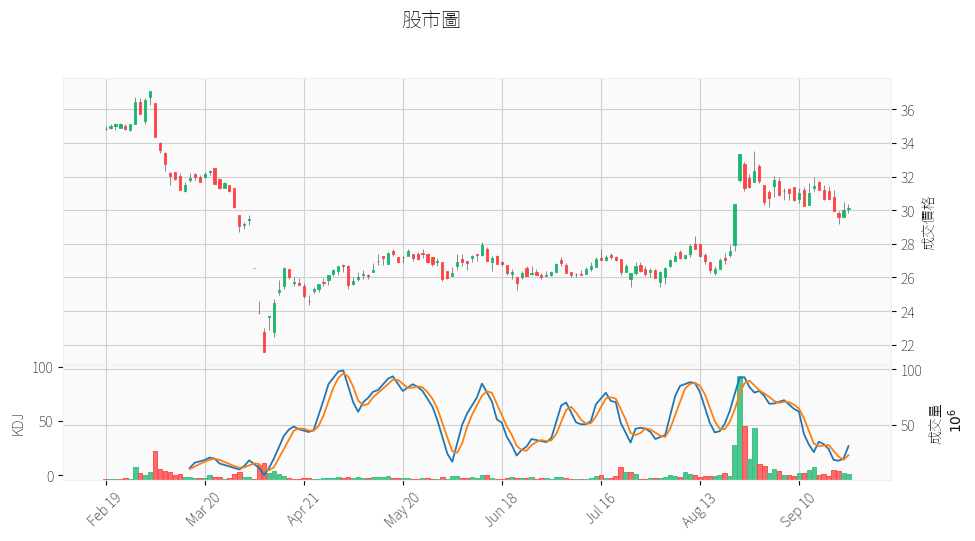

In [ ]:
Stock_No = '2352'

plt.rcParams['font.family'] = [ 'Noto Sans TC', 'sans-serif', 'Noto Sans CJK TC']
mpfrcpdict = { 'font.family' : [ 'Noto Sans TC', 'sans-serif', 'Noto Sans CJK TC']}
s = mpf.make_mpf_style(base_mpf_style='yahoo',rc=mpfrcpdict)
mpf.plot(Stocker2.data_ta.loc[Stock_No], type='candle', volume=True,

addplot=mpf.make_addplot(Stocker2.data_ta.loc[Stock_No][['K','D']], panel=1, ylabel='KDJ'),

title='股市圖', ylabel='成交價格', ylabel_lower='成交量', figratio=(20, 10),style=s)

In [ ]:
Stock_No = '2352'

apds = [
    mpf.make_addplot(Stocker2.data_ta.loc[Stock_No][['K','D']], panel=1, ylabel='KDJ'),
    mpf.make_addplot(Stocker2.data_ta.loc[Stock_No]['MACD_12_26_9'], panel=2, ylabel='MACD'),
    mpf.make_addplot(Stocker2.data_ta.loc[Stock_No]['MACDh_12_26_9'], panel=2, type='bar'),
    mpf.make_addplot(Stocker2.data_ta.loc[Stock_No]['MACDs_12_26_9'], panel=2),
    mpf.make_addplot(Stocker2.data_ta.loc[Stock_No]['RSI_14'],panel=3, ylabel='RSI')
]

plt.rcParams['font.family'] = [ 'Noto Sans TC', 'sans-serif', 'Noto Sans CJK TC']
mpfrcpdict = { 'font.family' : [ 'Noto Sans TC', 'sans-serif', 'Noto Sans CJK TC']}
s = mpf.make_mpf_style(base_mpf_style='yahoo',rc=mpfrcpdict)
mpf.plot(Stocker2.data_ta.loc[Stock_No], type='candle', volume=True,

addplot=apds,

title='股市圖', ylabel='成交價格', ylabel_lower='成交量', figratio=(20, 10),style=s)

In [ ]:
Stocker2.data_ta

open    high    low   close    volume   SMA_20  \
證券代號 交易日                                                                     
0050 2025-02-19 00:00:00  197.65  197.90  197.0  197.30  12820440      NaN   
     2025-02-20 00:00:00  196.95  196.95  195.1  196.55  15504294      NaN   
     2025-02-21 00:00:00  196.50  197.95  195.9  197.95   9097283      NaN   
     2025-02-24 00:00:00  196.15  196.40  195.5  196.20  14227193      NaN   
     2025-02-25 00:00:00  194.00  194.05  192.6  193.65  31389673      NaN   
...                          ...     ...    ...     ...       ...      ...   
9958 2025-09-22 00:00:00  175.50  175.50  171.0  171.50   1256521  175.100   
     2025-09-23 00:00:00  173.50  175.50  171.0  171.50   2138157  174.325   
     2025-09-24 00:00:00  171.00  181.50  169.0  173.50   4080385  173.375   
     2025-09-25 00:00:00  174.00  178.00  172.0  172.50   2231507  172.600   
     2025-09-26 00:00:00  172.50  174.00  170.0  172.00   1714413  172.025   

                             RSI_14      MACD     MACDh     MACDs          K  \
證券代號 交易日                                                                       
0050 2025-02-19 00:00:00        NaN       NaN       NaN       NaN        NaN   
     2025-02-20 00:00:00        NaN       NaN       NaN       NaN        NaN   
     2025-02-21 00:00:00        NaN       NaN       NaN       NaN        NaN   
     2025-02-24 00:00:00        NaN       NaN       NaN       NaN        NaN   
     2025-02-25 00:00:00        NaN       NaN       NaN       NaN        NaN   
...                             ...       ...       ...       ...        ...   
9958 2025-09-22 00:00:00  40.503123 -5.421332  0.543520 -5.964852  40.243523   
     2025-09-23 00:00:00  40.503123 -5.073176  0.713341 -5.786517  49.168009   
     2025-09-24 00:00:00  44.044889 -4.583047  0.962776 -5.545823  48.013090   
     2025-09-25 00:00:00  42.676929 -4.226586  1.055389 -5.281976  46.049556   
     2025-09-26 00:00:00  41.974952 -3.939028  1.074358 -5.013386  43.010753   

                                  D  STOCHh_14_3_3  
證券代號 交易日                                            
0050 2025-02-19 00:00:00        NaN            NaN  
     2025-02-20 00:00:00        NaN            NaN  
     2025-02-21 00:00:00        NaN            NaN  
     2025-02-24 00:00:00        NaN            NaN  
     2025-02-25 00:00:00        NaN            NaN  
...                             ...            ...  
9958 2025-09-22 00:00:00  24.780113      15.463410  
     2025-09-23 00:00:00  38.135824      11.032185  
     2025-09-24 00:00:00  45.808207       2.204883  
     2025-09-25 00:00:00  47.743552      -1.693996  
     2025-09-26 00:00:00  45.691133      -2.680380  

[4805807 rows x 13 columns]

In [ ]:
Stocker2.data_ta.loc["0050"]

NameError: name 'Stocker2' is not defined

In [ ]:
Stocker2.data_ta.loc["0050"].ta.rsi(14,append=True)

交易日
2025-02-19          NaN
2025-02-20          NaN
2025-02-21          NaN
2025-02-24          NaN
2025-02-25          NaN
                ...    
2025-09-22    68.166094
2025-09-23    72.684732
2025-09-24    72.159470
2025-09-25    69.980969
2025-09-26    60.619293
Name: RSI_14, Length: 148, dtype: float64

In [ ]:
Stocker2.data_ta.loc["0050"].ta.sma(20)

交易日
2025-02-19        NaN
2025-02-20        NaN
2025-02-21        NaN
2025-02-24        NaN
2025-02-25        NaN
               ...   
2025-09-22    54.2975
2025-09-23    54.5825
2025-09-24    54.8525
2025-09-25    55.1375
2025-09-26    55.3750
Name: SMA_20, Length: 148, dtype: float64

In [ ]:
macd = Stocker2.data_ta.loc["0050"].ta.macd()
macd['MACD_12_26_9']

交易日
2025-02-19         NaN
2025-02-20         NaN
2025-02-21         NaN
2025-02-24         NaN
2025-02-25         NaN
                ...   
2025-09-22    0.722189
2025-09-23    0.884070
2025-09-24    0.996835
2025-09-25    1.057870
2025-09-26    1.017851
Name: MACD_12_26_9, Length: 148, dtype: float64

In [ ]:
Stocker2.data_ta.loc["0050"].ta.stoch()

,STOCHk_14_3_3,STOCHd_14_3_3,STOCHh_14_3_3
交易日,,,
2025-02-19,NaN,NaN,NaN
2025-02-20,NaN,NaN,NaN
2025-02-21,NaN,NaN,NaN
2025-02-24,NaN,NaN,NaN
2025-02-25,NaN,NaN,NaN
...,...,...,...
2025-09-22,99.376947,97.188117,2.188830
2025-09-23,98.589545,98.025155,0.564390
2025-09-24,96.302546,98.089679,-1.787134


In [ ]:
import firebase_admin
from firebase_admin import firestore

# Application Default credentials are automatically created.
app = firebase_admin.initialize_app()
db = firestore.client()

DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

In [ ]:
with sqlite3.connect('stocker.db') as conn:
    Stocker2.data_ta.to_sql('Stocker_ta', conn, if_exists='append', index=True)